We will discuss how to bring all the different components together from this module, such as autograd, trainer, dataset, and dataloader, to train a network.

In [2]:
from mxnet import nd, gluon, init, autograd, metric

from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms

import matplotlib.pyplot as plt
from time import time

## Get Data

### Training Dataset: FashionMNIST

Similar but slightly more complicated dataset than MNIST called FashionMNIST, and the goal is no longer to classify numbers but claudine types instead. The dataset can be automatically downloaded through `gluon.data.vision.datasets` module.

The following code downloads the training dataset and shows the properties of the first example. Each example in this dataset is a 28 by 28 sides gray image which is presented as an NDRA with the shape format of height times width times channel. The label is a scalar.


In [3]:
mnist_train = datasets.FashionMNIST(train=True)
X, y =mnist_train[0]
print('X shape: %s dtype: %s' % (X.shape, X.dtype))
print("Number of images: %d" % len(mnist_train))

X shape: (28, 28, 1) dtype: <class 'numpy.uint8'>
Number of images: 60000


Next, we visualize the first six images.

In [57]:
def get_fashion_mnist_labels(labels):  #@save
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [61]:
def plot_images(X, y):
    images_count = len(X)
    labels = get_fashion_mnist_labels(y)
    fig, axes = plt.subplots(1,images_count, figsize=(10, 4))
    # fig.suptitle(title, fontsize=20)
    for ax, idx in zip(axes, range(images_count)):
        ax.imshow(X[idx].asnumpy())
        ax.set_title(labels[idx])
        ax.axis('off')
  

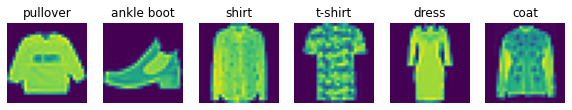

In [62]:
X, y = mnist_train[0:6]
plot_images(X, y)

We can see that they are low fidelity images of clothing items such as pullover, ankle boot, shirt, t-shirt, dress and coat.

### Transform dataset

- Channel first, float32
- Normalize

In order to feed data into a gluon network, we need to convert the images to the channel height times width, tensor format with floating point data type. This can be done by `transforms.ToTensor`. 

In addition, we normalize all pixel values with transform that normalize with the mean 0.13 and standard deviation 0.31.

We chain these two transforms together using `transforms.compose` and apply it to the first element of the data pair, namely the images.

In [63]:
transformer = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(0.13, 0.31)])
                                
mnist_train = mnist_train.transform_first(transformer)

### Data Loading

FashionMNIST is a subclass of `gluon.data.dataset`. In order to use it in training, we need to feed in randomized batches of examples through the network.

Here we use a batch size of 256 and four workers to process data in parallel which is often necessary especially for complex data transforms.

In [64]:
batch_size = 256

train_data = gluon.data.DataLoader(mnist_train,
                                    batch_size,
                                    shuffle=True,
                                    num_workers=4)

The return train data is an iterator that yields batches of images and label pairs.

In [66]:
for data, label in train_data:
    print(data.shape, label.shape)
    break

(256, 1, 28, 28) (256,)


### Define the model

We implement the same Lynette five network that's been introduced here using gluon builtin layers. The Lynette model consists of two convolution, then MaxPool followed by a series of dense layers with RELU activations for the convolutional layers, for all but the last dense layer. One difference here is that we change the weight initialization method to Xavier which is a popular choice for deep convolutional neural networks.

In [69]:
net = nn.Sequential()
with net.name_scope():
    net.add(
        nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(120, activation='relu'),
        nn.Dense(84, activation='relu'),
        nn.Dense(10)
    )
net.initialize(init=init.Xavier())

### Loss Function

We need to define the loss function that is minimized during training. We will use standard softmax cross entropy for the classification problem. It first performs softmax on the output to obtain the predicted probability and then compares the label with the cross entropy. The cross entropy will be high when the true class is assigned a low probability.

In [70]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

### Metric: Accuracy

To compute accuracy, we simply need to compare our model outputs or predictions to the ground truth label and compute what fraction of the outputs match the label. Mxnet has a predefined metrics library and we can just use the accuracy class defined there.


In [71]:
train_acc = metric.Accuracy()

### Optimization

We also need to define the gluon trainer that updates the model parameters during training. The optimization method we pick is the standard stochastic gradient descent method with constant learning rate of 0.1. The trainer is created with all parameters in the network.

In [72]:
trainer = gluon.Trainer(net.collect_params(),
                        'sgd', {'learning_rate':0.1})

### Training loop

Now we can implement the complete training loop. We will go through 10 epochs of training which means that we will iterate over the entire dataset 10 times, and for each epoch, we will record the training loss, training accuracy, and training speed. The training loop over batches occurs within the epoch loop. We iterate over the training data loader obtaining batches of training data and training labels. Using the autograd record scope, we compute the model forward pass. First we obtain the result of feeding the data batch to the network, and then we compute the loss using the network output and training level. This executions are performed within autograd so that the operations are recorded, ready for the backward pass when the gradients are calculated. This is done by calling the backward function on the loss as we have seen in previous sections. Finally, we can update parameters of the network using the computer gradients by calling trainer.step. This completes the training process on a single batch. Before moving onto the next batch in the epoch, we record the training loss and training accuracy for housekeeping purposes. At the end of each training epoch, we also print the loss in accuracy after that epoch.

In [79]:
for epoch in range(10):
    train_loss=0.
    tic = time()
    for data, label in train_data:
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()

        trainer.step(batch_size)

        train_loss += loss.mean().asscalar()
        train_acc.update(label, output)

    print(f"Epoch {epoch} Loss{(train_loss/len(train_data)):.3f} Acc: {train_acc.get()[1]:.3f} Perf: {len(mnist_train)/(time()-tic):.1f} img/sec")

net.save_parameters('trained_net.params')

Epoch 0 Loss0.830 Acc: 0.696 Perf: 10105.3 img/sec
Epoch 1 Loss0.468 Acc: 0.761 Perf: 9753.7 img/sec
Epoch 2 Loss0.405 Acc: 0.791 Perf: 9380.1 img/sec
Epoch 3 Loss0.366 Acc: 0.809 Perf: 9518.2 img/sec
Epoch 4 Loss0.340 Acc: 0.822 Perf: 9482.5 img/sec
Epoch 5 Loss0.318 Acc: 0.832 Perf: 9515.1 img/sec
Epoch 6 Loss0.301 Acc: 0.840 Perf: 9505.8 img/sec
Epoch 7 Loss0.289 Acc: 0.847 Perf: 9555.9 img/sec
Epoch 8 Loss0.276 Acc: 0.852 Perf: 9636.9 img/sec
Epoch 9 Loss0.271 Acc: 0.857 Perf: 9388.9 img/sec


As we can see, the loss is reducing after each epoch and the accuracy is increasing showing that a training process is working and the model is learning. After 10 epochs, we're able to get to about 90 percent accuracy on the training data. We save the model parameters with the safe parameters method after the 10 epochs of training. This does the parameter at the current state of training in the params file. 